# Textual entailment with TensorFlow

### Inspired by the O'Reilly article: <a href="https://www.oreilly.com/learning/textual-entailment-with-tensorflow">Textual entailment with TensorFlow</a> Using neural networks to explore natural language.
### By  Steven Hewitt - July 17, 2017
GitHub code repo: https://github.com/Steven-Hewitt/Entailment-with-Tensorflow

#### Note:
> This derived Notebook «Textual_Entailment_with_TensorFlow.ipynb» is a small contribution by Claude COULOMBE, PhD candidate, TÉLUQ / UQAM. The Notebook is running fine but the results are weak. Probably, you should train the model longer on more data.

### Introduction

Textual entailment is a simple exercise in logic that attempts to discern whether one sentence can be inferred from another. A computer program that takes on the task of textual entailment attempts to categorize an ordered pair of sentences into one of three categories. The first category, called “positive entailment,” occurs when you can use the first sentence to prove that a second sentence is true. The second category, “negative entailment,” is the inverse of positive entailment. This occurs when the first sentence can be used to disprove the second sentence. Finally, if the two sentences have no correlation, they are considered to have a “neutral entailment.”

> Textual Entailment is the task of determining whether a piece of text "R" for reference text accepted as truth involves another text called "H" for hypothesis text to be accepted as true, false, or indeterminable.

Textual entailment is useful as a component in much larger applications. For example, question-answering systems may use textual entailment to verify an answer from stored information. Textual entailment may also enhance document summarization by filtering out sentences that don’t include new information. Other natural language processing (NLP) systems find similar uses for entailment.

This article will guide you through how to build a simple and fast-to-train neural network to perform textual entailment using TensorFlow.

### Examples of textual entailment

In this section, we’ll walk through a few examples of textual entailment to illustrate what we mean by positive, negative, and neutral entailment. To begin, we’ll look at positive entailment—when you read, for example, that “Maurita and Jade both were at the scene of the car crash,” you can infer that “Multiple people saw the accident.” In this example sentence pair, we can prove the second sentence (also known as a “hypothesis”) from the first sentence (also called the “reference”), meaning that this represents a positive entailment. Given that Maurita and Jade were both there to view the crash, multiple people must have seen it. Note: “car crash” and “accident” have similar meanings, but they aren’t the same word. In fact, entailment doesn’t always mean that the sentences share words, as can be seen in this sentence pair, which only shares the word “the.”

Let’s consider another sentence pair. How, if at all, does the sentence “Two dogs played in the park with the old man” entail “There was only one canine in the park that day”? If there are two dogs, there must be at least two canines. Since the second sentence contradicts that idea, this is negative entailment.

Finally, to illustrate neutral entailment, we consider, how, if at all, the sentence “I played baseball with the kids” entails “The kids love ice cream.” Playing baseball and loving ice cream have absolutely nothing to do with each other. I could play baseball with ice cream lovers, and I could play baseball with ice cream haters (both are equally possible). Thus, the first sentence says nothing about the truth or falsehood of the second—implying neutral entailment.

<img src="https://d3ansictanv2wj.cloudfront.net/Figure_1-5c0c18591e46fb09c6f5ea7bf33c56fe.jpg"/>
<!-- <img src="images/Figure_1.jpg"/> -->
Figure 1. Types of entailment. Credit: Steven Hewitt.

### Representing words as numbers using word vectorization

Unfortunately for neural networks, they primarily work with numeric values. To get around this, we need to represent our words as numbers in some way. Ideally, these numbers mean something; for example, we could use the character codes of the letters in a word, but that doesn’t tell us anything about the meaning of it (which would mean that TensorFlow would have to do a lot of work to tell that “dog” and “canine” are close to the same concept). Turning similar meanings into something a neural network can understand happens by a process called word vectorization.

One common way to create word vectorizations is to have each word represent a single point in a very high-dimensional space. Words with similar representations should be relatively close together in this space. For example, each color has a representation that is usually very similar to other colors; demonstrations of this can be found in the <a href="https://www.tensorflow.org/tutorials/word2vec">TensorFlow tutorial on word vectorization</a>.

### Working with Stanford’s GloVe word vectorization + SNLI data set

For our purposes, we won’t need to create a new representation of words as numbers. There already exist quite a few fantastic general-purpose vector representations of words as well as ways to train even more specialized material if the general-purpose data isn’t enough.

The associated notebook for this article is designed to work with the <a href="http://nlp.stanford.edu/projects/glove/">pre-trained data for Stanford’s GloVe word vectorization</a>. We’ll be using the six-billion-token Wikipedia 2014 + Gigaword 5 vectors, since it’s the smallest and easiest to download. We’ll download the file programmatically, but keep in mind that it may take a while to run (it’s a fairly large file).

At the same time, we'll also be picking up our data set for textual entailment: <a href="http://nlp.stanford.edu/projects/snli/">Stanford’s SNLI data set</a>. We'll be using the development set in the interest of speed (it has only 10,000 sentence pairs), but if you're interested in getting better results and have time to spare for training, you can try using the full data set instead.

### Before we get started

In addition to installing TensorFlow version 1.0, make sure you’ve installed each of the following:

* Jupyter
* Numpy
* Matplotlib

To get a better sense of progress during network training, you're also welcome to install TQDM (`pip3 install tqdm`), but it's not required. Please access the code and Jupyter Notebook for this article on GitHub. We’ll be using <a href="http://nlp.stanford.edu/projects/snli/">Stanford’s SNLI data set</a> for our training, but we’ll download and extract the data we need using code from the Jupyter Notebook, so you don’t need to download it manually. If this is your first time working with TensorFlow, I’d encourage you to check out Aaron Schumacher’s article, <a href="https://www.oreilly.com/learning/hello-tensorflow">“Hello, Tensorflow.”</a>

We’ll start by doing all necessary imports, and we’ll let our Jupyter Notebook know that it should display graphs and images in the notebook itself.

In [11]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile

print("Python packages imported")

Python packages imported


#### Data download

The files we're about to use may take five minutes or more to download, so if you're following along by running the program in the corresponding notebook, feel free to start running the next few cells. In the meantime, let’s explore textual entailment in further detail.

In [12]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

snli_zip_file = "snli_1.0.zip"
snli_dev_file = "snli_1.0_dev.txt"
snli_full_dataset_file = "snli_1.0_train.txt"

In [15]:
from six.moves.urllib.request import urlretrieve
    
#large file - 862 MB
if (not os.path.isfile(glove_zip_file) and
    not os.path.isfile(glove_vectors_file)):
    urlretrieve ("http://nlp.stanford.edu/data/glove.6B.zip", 
                 glove_zip_file)

#medium-sized file - 94.6 MB
if (not os.path.isfile(snli_zip_file) and
    not os.path.isfile(snli_dev_file)):
    urlretrieve ("https://nlp.stanford.edu/projects/snli/snli_1.0.zip", 
                 snli_zip_file)

print("Data downloaded")

Data downloaded


In [16]:
def unzip_single_file(zip_file_name, output_file_name):
    """
        If the outFile is already created, don't recreate
        If the outFile does not exist, create it from the zipFile
    """
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return

unzip_single_file(glove_zip_file, glove_vectors_file)
unzip_single_file(snli_zip_file, snli_dev_file)
# unzip_single_file(snli_zip_file, snli_full_dataset_file)

print("Data uncompressed")

Data uncompressed


### Set-up a GloVe dictionary
Now that we have our GloVe vectors downloaded, we can load them into memory, deserializing the space separated format into a Python dictionary:

In [17]:
glove_wordmap = {}
with open(glove_vectors_file, "r") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

print("GloVe dictionary set-up")

GloVe dictionary set-up


### Transform input sentence to sequence of GloVe word-vectors
Once we have our words, we need our input to contain entire sentences and process it through a neural network. Let's start with making the sequence:

In [18]:
def sentence2sequence(sentence):
    """
     
    - Turns an input sentence into an (n,d) matrix, 
        where n is the number of tokens in the sentence
        and d is the number of dimensions each word vector has.
    
      Tensorflow doesn't need to be used here, as simply
      turning the sentence into a sequence based off our 
      mapping does not need the computational power that
      Tensorflow provides. Normal Python suffices for this task.
    """
    tokens = sentence.lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0 and i > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
            else:
                i = i-1
    return rows, words

print("Function to transform input sentence to sequence ready")

Function to transform input sentence to sequence ready


### What the computer sees when it looks at a sentence?

To better visualize the word vectorization process, and to see what the computer sees when it looks at a sentence, we can represent the vectors as images. Feel free to use the notebook to play around with visualizing your own sentences. Each row represents a single word, and the columns represent individual dimensions of the vectorized word. The vectorizations are trained in terms of relationships to other words, so what the representations actually mean is ambiguous. The computer can understand this vector language, and that’s the most important part to us. Generally speaking, two vectors that contain similar colors in the same positions represent words that are similar in meaning.

<img src="https://d3ansictanv2wj.cloudfront.net/Figure_2-3b82d4aee8a7bf022dbb6c05ff40af8b.jpg"/>
<!-- <img src="images/Figure_2.jpg"/> -->

<center>Figure 2. Sentences in vectorized form, visualized. Credit: Steven Hewitt.</center>

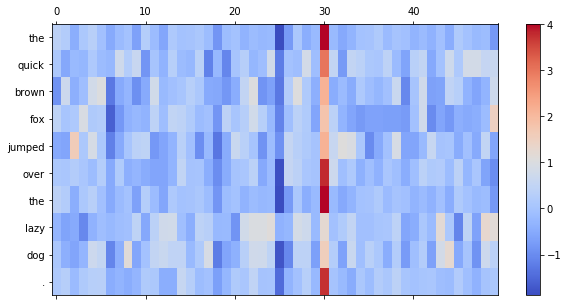

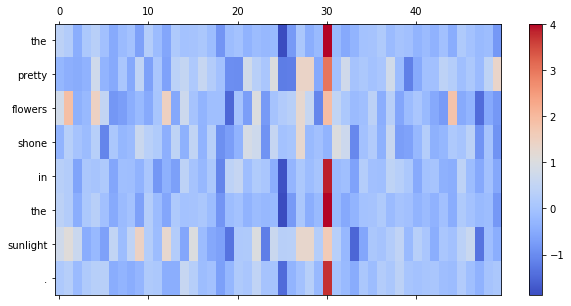

In [28]:
def visualize(sentence):
    rows, words = sentence2sequence(sentence)
    mat = np.vstack(rows)
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
#   shown = ax.matshow(mat, aspect="auto")
    shown = ax.matshow(mat, cmap='coolwarm', aspect="auto")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(shown)
    
    ax.set_yticklabels([""]+words)
    plt.show()
    
visualize("The quick brown fox jumped over the lazy dog.")
visualize("The pretty flowers shone in the sunlight.")

### Set-up the neural network

Unlike images, sentences are inherently sequential and can’t be constrained by size, so instead of fully connected forward-feeding networks that take in one input value and simply run until it produces a single output, we need a new type of network. We need...recurrence.

#### Vanilla recurrent networks

Recurrent Neural Networks (also known as RNNs) are a sequence-learning tool for neural networks. This type of neural network has only one layer’s worth of hidden inputs, which is re-used for each input from the sequence, along with a “memory” that’s passed ahead to the next input’s calculations. These are calculated using matrix multiplication where the matrix indices are trained weights, just like they are in a fully-connected layer. 

The same calculations are repeated for each input in the sequence, meaning that a single “layer” of a recurrent neural network can be unrolled into many layers. In fact, there will be as many layers as there are inputs in the sequence. This allows the network to process a very complex sentence. TensorFlow includes its own implementation of a vanilla RNN cell, `BasicRNNCell`, which can be added to your TensorFlow graph as follows:

In [27]:
rnn_size = 64
rnn = tf.contrib.rnn.BasicRNNCell(rnn_size)

#### The vanishing gradient problem

In theory, the network would be able to remember things from one of the first layers, much earlier in the sentence—even at the end of the sentence. The main problem with this form of recurrence is that, in practice, earlier data is completely drowned out by newer inputs and information that doesn’t end up being nearly as important. Recurrent neural networks, or at least a neural network with standard hidden units, often fail to hold on to information for long periods of time. This failure is known as the vanishing gradient problem.

The simplest way to visualize this is by example. In the simplest case, input and “memory” are roughly equally weighted. The first input into the data will affect approximately half of the first output (the other half being the starting “memory”), a quarter of the second output, then an eighth of the third output, and so on.

This means we can’t use vanilla recurrent networks, at least not if we want to keep track of both sentences in this pair. The solution is to use a different type of recurrent network layer. Perhaps the simplest of these is the long short-term memory layer, also known as an LSTM.

#### Utilizing LSTM

In an LSTM, instead of the input ($x_t$) always being used the same way every time in the calculation of current memory, the network makes a decision on how much the current values can affect the memory by an “input gate” (it), and makes another decision on what memory (ct) is forgotten by an appropriately named “forget gate” (ft), and finally makes a third decision on what parts of memory are sent to the next timestep (ht) by an “output gate” (ot).

<img src="https://d3ansictanv2wj.cloudfront.net/Figure_3-91a9d52b6ce666c7b66f2a046221ff80.jpg"/>

<center>Figure 3. A diagram showing the hidden units within an LSTM layer. Credit: Steven Hewitt<br/> (adapted from this <a href="https://en.wikipedia.org/wiki/Long_short-term_memory#/media/File:Long_Short_Term_Memory.png">similar image</a>, distributed under CC BY-SA 4.0).</center>
<!-- <img src="images/Figure_3.jpg" width=500/> -->

The combination of these three gates creates a choice: a single LSTM node can either keep information in long-term memory or keep it in short-term memory, but it can’t do both at the same time. Short-term memory LSTMs usually train to have relatively open input gates that let a lot of information in and forget many things often, while long-term memory LSTMs have tight input gates that only allow very small, very specific pieces of information in. This tightness means that it doesn’t lose its information easily, allowing for longer retention time.

In general, LSTMs are very cryptic. Different LSTM nodes in the same network may have vastly different gates that rely upon one another, such as perhaps having a short-term gate remember the word “not” in the sentence “John did not go to the store,” so that when the word “go” appears, a long-term gate could remember “not go” instead of “go.” Of course, this is a contrived example, and, in practice, these relationships are very complex to the point of being indecipherable.


#### Defining the hyperparameters for our network

Since we aren’t going to use a vanilla RNN layer in our network, let's clear out the graph and add an LSTM layer, which TensorFlow also includes by default. This is going to be the first part of our actual network, let's also define all the hyperparameters (aka constants) we'll need for the network, which we'll talk about as they come up:

In [31]:
# Hyperparameters setup
max_hypothesis_length, max_evidence_length = 30, 30
batch_size, vector_size, hidden_size = 128, 50, 64

lstm_size = hidden_size

weight_decay = 0.0001

learning_rate = 1

input_p, output_p = 0.5, 0.5

training_iterations_count = 100000

display_step = 10

def score_setup(row):
    convert_dict = {
      'entailment': 0,
      'neutral': 1,
      'contradiction': 2
    }
    score = np.zeros((3,))
    for x in range(1,6):
        tag = row["label"+str(x)]
        if tag in convert_dict: score[convert_dict[tag]] += 1
    return score / (1.0*np.sum(score))

def fit_to_size(matrix, shape):
    res = np.zeros(shape)
    slices = [slice(0,min(dim,shape[e])) for e, dim in enumerate(matrix.shape)]
    res[slices] = matrix[slices]
    return res

print("Hyperparameters set-up")

Hyperparameters set-up


In [32]:
def split_data_into_scores():
    import csv
    with open("snli_1.0_dev.txt","r") as data:
        train = csv.DictReader(data, delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        for row in train:
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence1"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence2"].lower())[0]))
            labels.append(row["gold_label"])
            scores.append(score_setup(row))
        
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                          for x in evi_sentences])
                                 
        return (hyp_sentences, evi_sentences), labels, np.array(scores)
    
data_feature_list, correct_values, correct_scores = split_data_into_scores()

l_h, l_e = max_hypothesis_length, max_evidence_length
N, D, H = batch_size, vector_size, hidden_size
l_seq = l_h + l_e

print("Data splitted")

Data splitted


We'll also reset the graph to not include the RNN cell we added earlier, since we won't be using that for this network:



In [ ]:
tf.reset_default_graph()

With both those out of the way, we can define our LSTM using TensorFlow as follows:

In [34]:
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

#### Implementing dropout, for regularization

If we simply used LSTM layers and nothing more, the network might read a lot of meaning into common, but inconsequential, words like “a,” “the,” and “and.” The network might incorrectly believe that it has found negative entailment if one sentence uses the phrase “an animal” and the other uses “the animal,” even if those phrases refer to the same object.

To solve this, we need to regulate to see if individual words end up being important to the meaning as a whole, and we do that by a process called “dropout.” Dropout is a regularization pattern in neural network design that revolves around dropping randomly selected hidden and visible units. As the size of a neural network increases, so does the number of parameters used to calculate the final result, each of which contributes to overfitting if trained all at once. In order to regularize for this, a portion of the units contained within the network are selected randomly and zeroed out temporarily during training, and their outputs are scaled appropriately during actual use.

Dropout on “standard” (i.e., fully connected) layers is also useful because it effectively trains multiple smaller networks, and then combines them during testing time. One of the constants in machine learning is that combining multiple models nearly always makes for a better method than a single model on its own, and dropout serves to turn a single neural network into multiple smaller neural networks that share some nodes, and thus some parameters, with the others.

A dropout layer has one hyperparameter known as p, which is simply the probability that each unit is kept in the network for that iteration of training. The units that are kept provide their outputs to the next layer, and the units that are not kept provide nothing. What follows is an example showing the difference between a fully connected network without dropout and a fully connected network with dropout during one iteration of training:

<img src="https://d3ansictanv2wj.cloudfront.net/Figure_4-d25389effee015dafb164e004d8e2db6.jpg"/>
<!-- <img src="images/Figure_4.jpg" width=600/> --> 
<center>Figure 4. On the left: A normal fully connected network. On the right: The same network during training, with p = 0.5.<br/>(Credit: Steven Hewitt)</center>

#### Tensorflow’s DropoutWrapper for recurrent layers

Unfortunately, dropout does not play particularly nicely with LSTM layers' internal gates. The loss of certain pieces of crucial memory means that complicated relationships required for first-order logic have a harder time forming with dropout, so for our LSTM layer, we’ll skip using dropout on internal gates, instead using it on everything else.  Thankfully, this is the default implementation of <a href="https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/DropoutWrapper">Tensorflow’s DropoutWrapper</a> for recurrent layers.

In [35]:
lstm_drop =  tf.contrib.rnn.DropoutWrapper(lstm, input_p, output_p)

#### Completing our neural network model

With all the explanations out of the way, we can finish up our model. The first step is tokenizing and using our GloVe dictionary to turn the two input sentences into a single sequence of vectors. Since we can’t effectively use dropout on information that gets passed within an LSTM, we’ll use dropout on features from words, and on final output instead -- effectively using dropout on the first and last layers from the unrolled LSTM network portions. 

You may notice that we use a bi-directional RNN, with two different LSTM units. This form of recurrent network runs both forward and backward through the input data, which allows the network to review both the hypothesis and the evidence (or reference) both independently and in relation to each other.

The final output from the LSTMs will be passed into a set of fully connected layers, and then from that we’ll get a single real-valued score that indicates how strong each of the kinds of entailment are, which we use to select our final result and our confidence in that result.

In [36]:
# N: The number of elements in each of our batches, 
#   which we use to train subsets of data for efficiency's sake.
# l_h: The maximum length of a hypothesis, or the second sentence.  This is
#   used because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# l_e: The maximum length of evidence, the first sentence.  This is used
#   because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# D: The size of our used GloVe or other vectors.
hyp = tf.placeholder(tf.float32, [N, l_h, D], 'hypothesis')
evi = tf.placeholder(tf.float32, [N, l_e, D], 'evidence')
y = tf.placeholder(tf.float32, [N, 3], 'label')
# hyp: Where the hypotheses will be stored during training.
# evi: Where the evidences will be stored during training.
# y: Where correct scores will be stored during training.

# lstm_size: the size of the gates in the LSTM, 
#    as in the first LSTM layer's initialization.
lstm_back = tf.contrib.rnn.BasicLSTMCell(lstm_size)
# lstm_back:  The LSTM used for looking backwards 
#   through the sentences, similar to lstm.

# input_p: the probability that inputs to the LSTM will be retained at each
#   iteration of dropout.
# output_p: the probability that outputs from the LSTM will be retained at 
#   each iteration of dropout.
lstm_drop_back = tf.contrib.rnn.DropoutWrapper(lstm_back, input_p, output_p)
# lstm_drop_back:  A dropout wrapper for lstm_back, like lstm_drop.

fc_initializer = tf.random_normal_initializer(stddev=0.1) 
# fc_initializer: initial values for the fully connected layer's weights.
# hidden_size: the size of the outputs from each lstm layer.  
#   Multiplied by 2 to account for the two LSTMs.
fc_weight = tf.get_variable('fc_weight', [2*hidden_size, 3], 
                            initializer = fc_initializer)
# fc_weight: Storage for the fully connected layer's weights.
fc_bias = tf.get_variable('bias', [3])
# fc_bias: Storage for the fully connected layer's bias.

# tf.GraphKeys.REGULARIZATION_LOSSES:  A key to a collection in the graph
#   designated for losses due to regularization.
#   In this case, this portion of loss is regularization on the weights
#   for the fully connected layer.
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(fc_weight)) 

x = tf.concat([hyp, evi], 1) # N, (Lh+Le), d
# Permuting batch_size and n_steps
x = tf.transpose(x, [1, 0, 2]) # (Le+Lh), N, d
# Reshaping to (n_steps*batch_size, n_input)
x = tf.reshape(x, [-1, vector_size]) # (Le+Lh)*N, d
# Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
x = tf.split(x, l_seq,)

# x: the inputs to the bidirectional_rnn

# tf.contrib.rnn.static_bidirectional_rnn: Runs the input through
#   two recurrent networks, one that runs the inputs forward and one
#   that runs the inputs in reversed order, combining the outputs.
rnn_outputs, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm, lstm_back,
                                                            x, dtype=tf.float32)
# rnn_outputs: the list of LSTM outputs, as a list. 
#   What we want is the latest output, rnn_outputs[-1]

classification_scores = tf.matmul(rnn_outputs[-1], fc_weight) + fc_bias
# The scores are relative certainties for how likely the output matches
#   a certain entailment: 
#     0: Positive entailment
#     1: Neutral entailment
#     2: Negative entailment

### Showing TensorFlow how to calculate loss and accuracy

In order to test the accuracy and begin to add in optimization constraints, we need to show TensorFlow how to calculate the accuracy, or -- the percentage of correctly predicted labels.

We also need to determine a loss, to show how poorly the network is doing. Since we have both classification scores and optimal scores, the choice here is using a variation on softmax loss from Tensorflow: `tf.nn.softmax_cross_entropy_with_logits`. We add in regularization losses to help with overfitting, and then prepare an optimizer to learn how to reduce the loss.

In [38]:
with tf.variable_scope('Accuracy'):
    predicts = tf.cast(tf.argmax(classification_scores, 1), 'int32')
    y_label = tf.cast(tf.argmax(y, 1), 'int32')
    corrects = tf.equal(predicts, y_label)
    num_corrects = tf.reduce_sum(tf.cast(corrects, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

with tf.variable_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        logits = classification_scores, labels = y)
    loss = tf.reduce_mean(cross_entropy)
    total_loss = loss + weight_decay * tf.add_n(
        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)

opt_op = optimizer.minimize(total_loss)

### Train the model

Finally, we can train the network! If you installed TQDM, you can use it to keep track of progress as the network trains.


In [39]:
# Initialize variables
init = tf.global_variables_initializer()

# Use TQDM if installed
tqdm_installed = False
try:
    from tqdm import tqdm
    tqdm_installed = True
except:
    pass

# Launch the Tensorflow session
sess = tf.Session()
sess.run(init)

# training_iterations_count: The number of data pieces to train on in total
# batch_size: The number of data pieces per batch
training_iterations = range(0,training_iterations_count,batch_size)
if tqdm_installed:
    # Add a progress bar if TQDM is installed
    training_iterations = tqdm(training_iterations)

for i in training_iterations:

    # Select indices for a random data subset
    batch = np.random.randint(data_feature_list[0].shape[0], size=batch_size)
    
    # Use the selected subset indices to initialize the graph's 
    #   placeholder values
    hyps, evis, ys = (data_feature_list[0][batch,:],
                      data_feature_list[1][batch,:],
                      correct_scores[batch])
    
    # Run the optimization with these initialized values
    sess.run([opt_op], feed_dict={hyp: hyps, evi: evis, y: ys})
    # display_step: how often the accuracy and loss should 
    #   be tested and displayed.
    if (i/batch_size) % display_step == 0:
        # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Calculate batch loss
        tmp_loss = sess.run(loss, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Display results
        print("Iter " + str(i/batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(tmp_loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))

  0%|          | 3/782 [00:00<07:23,  1.75it/s]

Iter 0.0, Minibatch Loss= 1.088066, Training Accuracy= 0.39844


  2%|▏         | 13/782 [00:02<01:47,  7.14it/s]

Iter 10.0, Minibatch Loss= 1.100138, Training Accuracy= 0.34375


  3%|▎         | 22/782 [00:03<01:30,  8.37it/s]

Iter 20.0, Minibatch Loss= 1.084840, Training Accuracy= 0.38281


  4%|▍         | 32/782 [00:04<01:45,  7.14it/s]

Iter 30.0, Minibatch Loss= 1.096247, Training Accuracy= 0.35938


  5%|▌         | 42/782 [00:05<01:53,  6.50it/s]

Iter 40.0, Minibatch Loss= 1.093393, Training Accuracy= 0.35938


  7%|▋         | 53/782 [00:07<01:27,  8.37it/s]

Iter 50.0, Minibatch Loss= 1.090575, Training Accuracy= 0.37500


  8%|▊         | 63/782 [00:08<01:22,  8.69it/s]

Iter 60.0, Minibatch Loss= 1.088268, Training Accuracy= 0.38281


  9%|▉         | 73/782 [00:09<01:24,  8.40it/s]

Iter 70.0, Minibatch Loss= 1.076672, Training Accuracy= 0.43750


 11%|█         | 83/782 [00:10<01:16,  9.13it/s]

Iter 80.0, Minibatch Loss= 1.096250, Training Accuracy= 0.35156


 12%|█▏        | 93/782 [00:11<01:16,  9.00it/s]

Iter 90.0, Minibatch Loss= 1.085249, Training Accuracy= 0.44531


 13%|█▎        | 102/782 [00:12<01:38,  6.88it/s]

Iter 100.0, Minibatch Loss= 1.078328, Training Accuracy= 0.45312


 14%|█▍        | 113/782 [00:14<01:34,  7.09it/s]

Iter 110.0, Minibatch Loss= 1.070820, Training Accuracy= 0.48438


 16%|█▌        | 122/782 [00:15<01:31,  7.21it/s]

Iter 120.0, Minibatch Loss= 1.081748, Training Accuracy= 0.39844


 17%|█▋        | 132/782 [00:17<01:35,  6.80it/s]

Iter 130.0, Minibatch Loss= 1.052584, Training Accuracy= 0.46875


 18%|█▊        | 143/782 [00:18<01:25,  7.45it/s]

Iter 140.0, Minibatch Loss= 1.064394, Training Accuracy= 0.47656


 19%|█▉        | 152/782 [00:19<01:31,  6.89it/s]

Iter 150.0, Minibatch Loss= 1.088482, Training Accuracy= 0.39844


 21%|██        | 162/782 [00:21<01:34,  6.57it/s]

Iter 160.0, Minibatch Loss= 1.098563, Training Accuracy= 0.36719


 22%|██▏       | 172/782 [00:22<01:22,  7.38it/s]

Iter 170.0, Minibatch Loss= 1.064505, Training Accuracy= 0.42188


 23%|██▎       | 182/782 [00:23<01:11,  8.37it/s]

Iter 180.0, Minibatch Loss= 1.080027, Training Accuracy= 0.35938


 25%|██▍       | 193/782 [00:25<01:12,  8.17it/s]

Iter 190.0, Minibatch Loss= 1.091725, Training Accuracy= 0.42969


 26%|██▌       | 202/782 [00:26<01:26,  6.68it/s]

Iter 200.0, Minibatch Loss= 1.041403, Training Accuracy= 0.53125


 27%|██▋       | 212/782 [00:28<01:36,  5.89it/s]

Iter 210.0, Minibatch Loss= 1.078522, Training Accuracy= 0.38281


 28%|██▊       | 221/782 [00:29<01:16,  7.31it/s]

Iter 220.0, Minibatch Loss= 1.082905, Training Accuracy= 0.44531


 30%|██▉       | 232/782 [00:30<01:34,  5.83it/s]

Iter 230.0, Minibatch Loss= 1.083336, Training Accuracy= 0.38281


 31%|███       | 242/782 [00:32<01:22,  6.54it/s]

Iter 240.0, Minibatch Loss= 1.074814, Training Accuracy= 0.41406


 32%|███▏      | 252/782 [00:33<01:13,  7.24it/s]

Iter 250.0, Minibatch Loss= 1.077455, Training Accuracy= 0.39062


 33%|███▎      | 261/782 [00:34<01:12,  7.24it/s]

Iter 260.0, Minibatch Loss= 1.078841, Training Accuracy= 0.47656


 35%|███▍      | 273/782 [00:36<01:01,  8.29it/s]

Iter 270.0, Minibatch Loss= 1.088600, Training Accuracy= 0.37500


 36%|███▌      | 282/782 [00:37<01:10,  7.11it/s]

Iter 280.0, Minibatch Loss= 1.069690, Training Accuracy= 0.50000


 37%|███▋      | 292/782 [00:38<01:02,  7.79it/s]

Iter 290.0, Minibatch Loss= 1.077397, Training Accuracy= 0.38281


 39%|███▊      | 302/782 [00:39<01:00,  7.88it/s]

Iter 300.0, Minibatch Loss= 1.076930, Training Accuracy= 0.44531


 40%|███▉      | 312/782 [00:41<01:01,  7.68it/s]

Iter 310.0, Minibatch Loss= 1.081758, Training Accuracy= 0.40625


 41%|████▏     | 323/782 [00:42<01:03,  7.22it/s]

Iter 320.0, Minibatch Loss= 1.060830, Training Accuracy= 0.41406


 43%|████▎     | 333/782 [00:43<01:01,  7.31it/s]

Iter 330.0, Minibatch Loss= 1.071990, Training Accuracy= 0.40625


 44%|████▍     | 343/782 [00:45<01:00,  7.28it/s]

Iter 340.0, Minibatch Loss= 1.043315, Training Accuracy= 0.51562


 45%|████▌     | 352/782 [00:46<01:02,  6.83it/s]

Iter 350.0, Minibatch Loss= 1.062797, Training Accuracy= 0.46094


 46%|████▋     | 362/782 [00:47<00:56,  7.39it/s]

Iter 360.0, Minibatch Loss= 1.042565, Training Accuracy= 0.50781


 48%|████▊     | 373/782 [00:49<00:47,  8.68it/s]

Iter 370.0, Minibatch Loss= 1.066197, Training Accuracy= 0.42969


 49%|████▉     | 383/782 [00:50<00:46,  8.62it/s]

Iter 380.0, Minibatch Loss= 1.020965, Training Accuracy= 0.53906


 50%|█████     | 392/782 [00:51<00:49,  7.84it/s]

Iter 390.0, Minibatch Loss= 1.046218, Training Accuracy= 0.45312


 52%|█████▏    | 403/782 [00:52<00:39,  9.69it/s]

Iter 400.0, Minibatch Loss= 1.045308, Training Accuracy= 0.52344


 53%|█████▎    | 413/782 [00:53<00:36, 10.17it/s]

Iter 410.0, Minibatch Loss= 1.038693, Training Accuracy= 0.52344


 54%|█████▍    | 423/782 [00:54<00:35, 10.16it/s]

Iter 420.0, Minibatch Loss= 1.055968, Training Accuracy= 0.43750


 55%|█████▌    | 433/782 [00:55<00:33, 10.38it/s]

Iter 430.0, Minibatch Loss= 1.037158, Training Accuracy= 0.44531


 57%|█████▋    | 443/782 [00:56<00:32, 10.32it/s]

Iter 440.0, Minibatch Loss= 1.054733, Training Accuracy= 0.48438


 58%|█████▊    | 453/782 [00:57<00:34,  9.50it/s]

Iter 450.0, Minibatch Loss= 1.066701, Training Accuracy= 0.45312


 59%|█████▉    | 461/782 [00:58<00:35,  9.09it/s]

Iter 460.0, Minibatch Loss= 2.052315, Training Accuracy= 0.29688


 60%|██████    | 472/782 [00:59<00:33,  9.28it/s]

Iter 470.0, Minibatch Loss= 1.093284, Training Accuracy= 0.42969


 62%|██████▏   | 483/782 [01:00<00:39,  7.62it/s]

Iter 480.0, Minibatch Loss= 1.029379, Training Accuracy= 0.49219


 63%|██████▎   | 493/782 [01:01<00:36,  7.98it/s]

Iter 490.0, Minibatch Loss= 1.077508, Training Accuracy= 0.42969


 64%|██████▍   | 503/782 [01:03<00:32,  8.57it/s]

Iter 500.0, Minibatch Loss= 1.055784, Training Accuracy= 0.53125


 65%|██████▌   | 512/782 [01:04<00:35,  7.54it/s]

Iter 510.0, Minibatch Loss= 1.077108, Training Accuracy= 0.46875


 67%|██████▋   | 523/782 [01:05<00:27,  9.42it/s]

Iter 520.0, Minibatch Loss= 1.077881, Training Accuracy= 0.42969


 68%|██████▊   | 533/782 [01:06<00:30,  8.03it/s]

Iter 530.0, Minibatch Loss= 1.023267, Training Accuracy= 0.46875


 69%|██████▉   | 541/782 [01:07<00:28,  8.32it/s]

Iter 540.0, Minibatch Loss= 1.016126, Training Accuracy= 0.50000


 71%|███████   | 553/782 [01:08<00:29,  7.68it/s]

Iter 550.0, Minibatch Loss= 1.051720, Training Accuracy= 0.45312


 72%|███████▏  | 561/782 [01:09<00:27,  7.95it/s]

Iter 560.0, Minibatch Loss= 1.012270, Training Accuracy= 0.53125


 73%|███████▎  | 573/782 [01:11<00:24,  8.40it/s]

Iter 570.0, Minibatch Loss= 1.053488, Training Accuracy= 0.48438


 74%|███████▍  | 582/782 [01:12<00:30,  6.56it/s]

Iter 580.0, Minibatch Loss= 1.021688, Training Accuracy= 0.46094


 76%|███████▌  | 593/782 [01:13<00:24,  7.66it/s]

Iter 590.0, Minibatch Loss= 1.044932, Training Accuracy= 0.54688


 77%|███████▋  | 602/782 [01:14<00:22,  8.07it/s]

Iter 600.0, Minibatch Loss= 1.030654, Training Accuracy= 0.45312


 78%|███████▊  | 612/782 [01:15<00:18,  9.11it/s]

Iter 610.0, Minibatch Loss= 1.019260, Training Accuracy= 0.46094


 79%|███████▉  | 621/782 [01:16<00:21,  7.58it/s]

Iter 620.0, Minibatch Loss= 1.016721, Training Accuracy= 0.45312


 81%|████████  | 633/782 [01:18<00:16,  9.08it/s]

Iter 630.0, Minibatch Loss= 1.020480, Training Accuracy= 0.47656


 82%|████████▏ | 643/782 [01:19<00:16,  8.62it/s]

Iter 640.0, Minibatch Loss= 1.017708, Training Accuracy= 0.46875


 83%|████████▎ | 651/782 [01:20<00:18,  6.95it/s]

Iter 650.0, Minibatch Loss= 1.015517, Training Accuracy= 0.52344


 85%|████████▍ | 662/782 [01:21<00:13,  8.92it/s]

Iter 660.0, Minibatch Loss= 1.014639, Training Accuracy= 0.48438


 86%|████████▌ | 672/782 [01:22<00:13,  7.95it/s]

Iter 670.0, Minibatch Loss= 1.034306, Training Accuracy= 0.47656


 87%|████████▋ | 683/782 [01:23<00:10,  9.28it/s]

Iter 680.0, Minibatch Loss= 1.039952, Training Accuracy= 0.46094


 88%|████████▊ | 692/782 [01:24<00:11,  7.73it/s]

Iter 690.0, Minibatch Loss= 1.064102, Training Accuracy= 0.49219


 90%|████████▉ | 703/782 [01:25<00:08,  9.27it/s]

Iter 700.0, Minibatch Loss= 0.992308, Training Accuracy= 0.52344


 91%|█████████ | 712/782 [01:26<00:08,  8.32it/s]

Iter 710.0, Minibatch Loss= 1.053722, Training Accuracy= 0.45312


 92%|█████████▏| 723/782 [01:28<00:06,  9.08it/s]

Iter 720.0, Minibatch Loss= 1.007184, Training Accuracy= 0.50000


 94%|█████████▎| 733/782 [01:29<00:04,  9.91it/s]

Iter 730.0, Minibatch Loss= 1.037127, Training Accuracy= 0.48438


 95%|█████████▍| 742/782 [01:30<00:04,  9.07it/s]

Iter 740.0, Minibatch Loss= 1.050359, Training Accuracy= 0.49219


 96%|█████████▌| 751/782 [01:31<00:03,  8.05it/s]

Iter 750.0, Minibatch Loss= 1.044975, Training Accuracy= 0.49219


 97%|█████████▋| 762/782 [01:32<00:02,  8.36it/s]

Iter 760.0, Minibatch Loss= 1.038653, Training Accuracy= 0.46875


 99%|█████████▉| 773/782 [01:33<00:01,  8.08it/s]

Iter 770.0, Minibatch Loss= 0.985656, Training Accuracy= 0.57812


100%|██████████| 782/782 [01:34<00:00,  7.44it/s]

Iter 780.0, Minibatch Loss= 1.016005, Training Accuracy= 0.50000


### Test the model

Your network is now trained! You should see accuracies around 50-55%, which can be improved by careful modification of hyperparameters and increasing the dataset size to include the entire training set. Usually, this will correspond with an increase in training time.

Feel free to modify the following code by inserting your own sentences:

In [53]:
# evidences = ["Maurita and Jade both were at the scene of the car crash."]
# hypotheses = ["Multiple people saw the accident."]
# Negative entailment WRONG!

# evidences = ["John is a man and Janet is a woman"]
# hypotheses = ["There is two people"]
# Positive entailment

# evidences = ["Socrate is a man and all man are mortal"]
# hypotheses = ["Socrate is mortal"]
# Positive entailment

# evidences = ["Socrate is a man and all man are mortal"]
# hypotheses = ["Socrate is washing dishes"]
# Positive entailment

# evidences = ["Socrate is a man who plays golf"]
# hypotheses = ["He is a sportman"]
# Positive entailment

# evidences = ["Socrate gave a man a shot"]
# hypotheses = ["The sky is blue"]
# Negative entailment

# evidences = ["Two dogs played in the park with the old man"]
# hypotheses = ["There was only one canine in the park that day"]
# Neutral entailment

# evidences = ["I played baseball with the kids"]
# hypotheses = ["The kids love ice cream"]
# Negative entailment

sentence1 = [fit_to_size(np.vstack(sentence2sequence(evidence)[0]),
                         (30, 50)) for evidence in evidences]

sentence2 = [fit_to_size(np.vstack(sentence2sequence(hypothesis)[0]),
                         (30,50)) for hypothesis in hypotheses]

prediction = sess.run(classification_scores, feed_dict={hyp: (sentence1 * N),
                                                        evi: (sentence2 * N),
                                                        y: [[0,0,0]]*N})
print(["Positive", "Neutral", "Negative"][np.argmax(prediction[0])]+
      " entailment")

Negative entailment


Finally, once we're done playing with our model, we'll close the session to free up system resources.

In [ ]:
sess.close()

### Interested in developing more results?

The design focus of this network was creating a simple system that was easy and quick to train. In order to get more accurate results, you may want to consider:

* Adding more layers of LSTMs.
* Using alternative types of RNN layers, such as Gated Recurrent Units (GRUs). TensorFlow also includes an implementation of GRUs.
* Adding more hidden units. If you do this, increase regularization and dropout strengths to account for the fact that there are more parameters in the network.
* Experimentation with other kinds of networks entirely!

This post is a collaboration between O'Reilly and TensorFlow. See our statement of editorial independence.

Steven Hewitt is currently a graduate student in the Computer Science division of the EECS department at the University of California, Berkeley. His academic interests include AI, natural language processing, education, and robotics. His research endeavors currently include teaching programs to understand code patterns and display them in a way relevant to humans, word embedding methods, and question-answering systems. When he’s not attending classes or coding, you may find him composing music or generating fractal flame art.